In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [4]:
y_test = data.iloc[-24*7:]['Usage_kWh'].values

y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [5]:
from sklearn.neural_network import MLPRegressor

In [50]:
df_results = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions = pd.DataFrame(None)
df_predictions['True'] = y_test

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def r2(y_true, y_pred):
    ssres = sum((y_true-y_pred)**2)
    sstotal = sum((y_true-np.mean(y_true))**2)
    return 1 - ssres/sstotal

In [52]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])

In [343]:
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}
Tuner = False

In [54]:
model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [55]:
y_pred = []
start_prediction = time.time()
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [56]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,13348.052421,86.189261,0.88502,48.995106,None,0.068313


In [57]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

In [58]:
model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [59]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [60]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,13348.052421,86.189261,0.885020,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,14041.860142,89.685123,0.879043,131.061869,None,0.003999


In [61]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])

In [62]:
model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [63]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [64]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,13348.052421,86.189261,0.885020,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,14041.860142,89.685123,0.879043,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,14414.157068,91.974853,0.875836,188.546217,None,0.000000


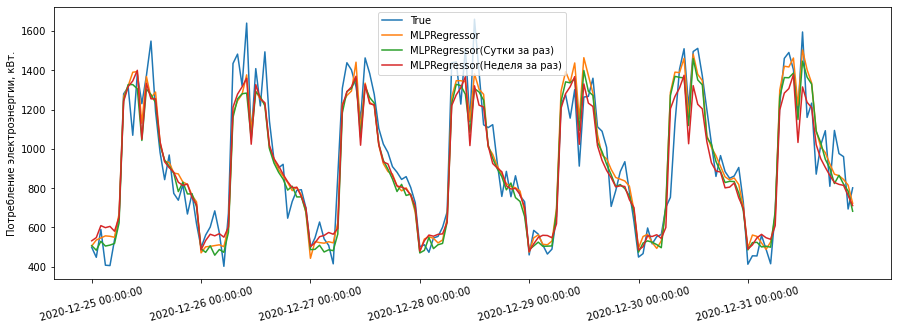

In [65]:
dates_list = []
for d in data[-24*7:]['Date']:
    if d not in dates_list:
        dates_list.append(d)

plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

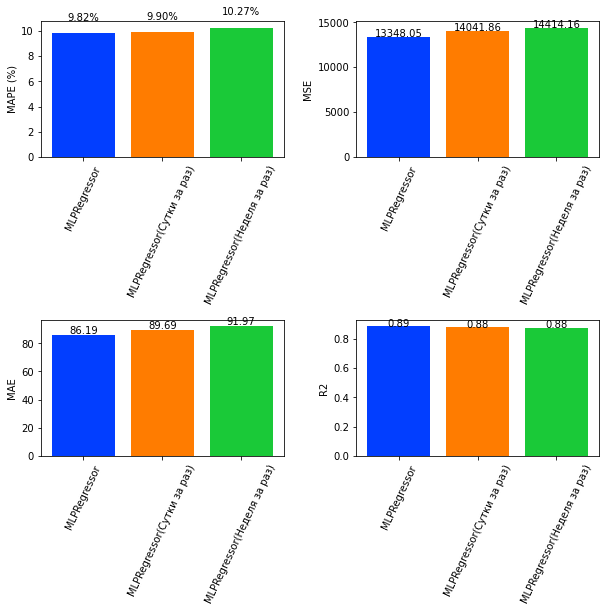

In [66]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

In [328]:
from sklearn.model_selection import GridSearchCV

In [74]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])

model = MLPRegressor()
parameters = {'activation' : ['logistic', 'tanh', 'relu'],
             'max_iter':range(150, 451, 50)}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

model_name = 'MLPRegressor'
params = {'activation': gridsearch.best_params_['activation'], 
         'max_iter':gridsearch.best_params_['max_iter']}
Tuner = True
print(params)

model = MLPRegressor(activation=params['activation'], max_iter=params['max_iter'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

{'activation': 'relu', 'max_iter': 400}


In [75]:
y_pred = []
start_prediction = time.time()
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [76]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':end_tuner-start_tuner,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,13348.052421,86.189261,0.885020,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,14041.860142,89.685123,0.879043,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,14414.157068,91.974853,0.875836,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,14497.842010,92.976614,0.875116,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,{'activation': 'relu'},10.557154,15005.806114,94.592967,0.870740,93.365308,2515.142346,0.008001
5,MLPRegressor(Наблюдение за раз),True,"{'activation': 'relu', 'max_iter': 400}",12.741389,21804.819327,120.208786,0.812173,38.755914,2060.426181,0.031263


In [78]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

model = MLPRegressor()
parameters = {'activation' : ['logistic', 'tanh', 'relu'],
             'max_iter':range(150, 451, 50)}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

model_name = 'MLPRegressor'
params = {'activation': gridsearch.best_params_['activation'], 
         'max_iter':gridsearch.best_params_['max_iter']}
Tuner = True
print(params)

model = MLPRegressor(activation=params['activation'], max_iter=params['max_iter'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

{'activation': 'relu', 'max_iter': 300}


In [79]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [80]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':end_tuner-start_tuner,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,13348.052421,86.189261,0.885020,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,14041.860142,89.685123,0.879043,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,14414.157068,91.974853,0.875836,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,14497.842010,92.976614,0.875116,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,{'activation': 'relu'},10.557154,15005.806114,94.592967,0.870740,93.365308,2515.142346,0.008001
5,MLPRegressor(Наблюдение за раз),True,"{'activation': 'relu', 'max_iter': 400}",12.741389,21804.819327,120.208786,0.812173,38.755914,2060.426181,0.031263
6,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,13672.467223,86.683387,0.882225,78.375693,2591.394983,0.020331


In [108]:
df_results.to_csv('MLP_results.csv')
df_predictions.to_csv('MLP_predictions.csv')

In [100]:
names_models = [f'{row.Model}\n({row.Tuner})' for index, row in df_results.iterrows()]
names_models

['MLPRegressor(Наблюдение за раз)\n(False)',
 'MLPRegressor(Сутки за раз)\n(False)',
 'MLPRegressor(Неделя за раз)\n(False)',
 'MLPRegressor(Наблюдение за раз)\n(True)',
 'MLPRegressor(Сутки за раз)\n(True)']

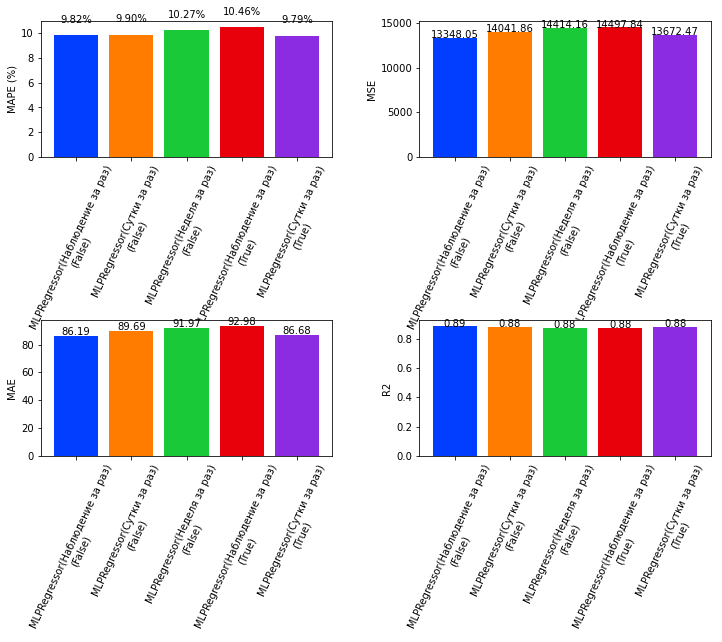

In [102]:
colors = sns.color_palette("bright", n_colors=len(names_models))
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=names_models, height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(names_models, rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=names_models, height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(names_models, rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=names_models, height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(names_models, rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=names_models, height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(names_models, rotation=65);

In [103]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW]-np.mean(y))/np.std(y))
    
model_name = 'MLPRegressor (стандартизация)'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

y_pred = []
start_prediction = time.time()
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,1.334805e+04,86.189261,8.850199e-01,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,1.404186e+04,89.685123,8.790434e-01,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,1.441416e+04,91.974853,8.758365e-01,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,1.449784e+04,92.976614,8.751156e-01,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,1.367247e+04,86.683387,8.822254e-01,78.375693,2591.394983,0.020331
5,MLPRegressor (стандартизация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",49966.434520,1.939607e+11,428689.419978,-1.670776e+06,90.518631,None,0.064005


In [104]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24]-np.mean(y))/np.std(y))
    
model_name = 'MLPRegressor (стандартизация)'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,1.334805e+04,86.189261,8.850199e-01,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,1.404186e+04,89.685123,8.790434e-01,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,1.441416e+04,91.974853,8.758365e-01,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,1.449784e+04,92.976614,8.751156e-01,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,1.367247e+04,86.683387,8.822254e-01,78.375693,2591.394983,0.020331
5,MLPRegressor (стандартизация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",49966.434520,1.939607e+11,428689.419978,-1.670776e+06,90.518631,None,0.064005
6,MLPRegressor (стандартизация)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",39546.597515,1.345475e+11,352281.947723,-1.158991e+06,34.936232,None,0.004002


In [105]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    y_train.append((y[i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    
model_name = 'MLPRegressor (нормализация)'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

y_pred = []
start_prediction = time.time()
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * (np.max(y) - np.min(y)) + np.min(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,1.334805e+04,8.618926e+01,8.850199e-01,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,1.404186e+04,8.968512e+01,8.790434e-01,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,1.441416e+04,9.197485e+01,8.758365e-01,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,1.449784e+04,9.297661e+01,8.751156e-01,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,1.367247e+04,8.668339e+01,8.822254e-01,78.375693,2591.394983,0.020331
5,MLPRegressor (стандартизация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",49966.434520,1.939607e+11,4.286894e+05,-1.670776e+06,90.518631,None,0.064005
6,MLPRegressor (стандартизация)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",39546.597515,1.345475e+11,3.522819e+05,-1.158991e+06,34.936232,None,0.004002
7,MLPRegressor (нормализация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",118919.053481,1.575876e+12,1.131464e+06,-1.357459e+07,6.762070,None,0.054005


In [106]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    y_train.append((y[i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    
model_name = 'MLPRegressor (нормализация)'
params = {'hidden_layer_sizes': (100,),
        'activation': 'sigmoid'}
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

y_pred = []
start_prediction = time.time()
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * (np.max(y) - np.min(y)) + np.min(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,1.334805e+04,8.618926e+01,8.850199e-01,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,1.404186e+04,8.968512e+01,8.790434e-01,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,1.441416e+04,9.197485e+01,8.758365e-01,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,1.449784e+04,9.297661e+01,8.751156e-01,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,1.367247e+04,8.668339e+01,8.822254e-01,78.375693,2591.394983,0.020331
5,MLPRegressor (стандартизация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",49966.434520,1.939607e+11,4.286894e+05,-1.670776e+06,90.518631,None,0.064005
6,MLPRegressor (стандартизация)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",39546.597515,1.345475e+11,3.522819e+05,-1.158991e+06,34.936232,None,0.004002
7,MLPRegressor (нормализация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",118919.053481,1.575876e+12,1.131464e+06,-1.357459e+07,6.762070,None,0.054005
8,MLPRegressor (нормализация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",256225.421458,5.606313e+12,2.280564e+06,-4.829277e+07,7.267928,None,0.043005


In [107]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24]-np.mean(y))/np.std(y))
    
model_name = 'MLPRegressor (стандартизация)'
params = {'hidden_layer_sizes': (100,),
        'activation': 'sigmoid'}
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.823182,1.334805e+04,8.618926e+01,8.850199e-01,48.995106,None,0.068313
1,MLPRegressor(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.895109,1.404186e+04,8.968512e+01,8.790434e-01,131.061869,None,0.003999
2,MLPRegressor(Неделя за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.273241,1.441416e+04,9.197485e+01,8.758365e-01,188.546217,None,0.000000
3,MLPRegressor(Наблюдение за раз),True,{'activation': 'relu'},10.463797,1.449784e+04,9.297661e+01,8.751156e-01,17.184196,1979.647132,0.031262
4,MLPRegressor(Сутки за раз),True,"{'activation': 'relu', 'max_iter': 300}",9.792794,1.367247e+04,8.668339e+01,8.822254e-01,78.375693,2591.394983,0.020331
5,MLPRegressor (стандартизация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",49966.434520,1.939607e+11,4.286894e+05,-1.670776e+06,90.518631,None,0.064005
6,MLPRegressor (стандартизация)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",39546.597515,1.345475e+11,3.522819e+05,-1.158991e+06,34.936232,None,0.004002
7,MLPRegressor (нормализация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",118919.053481,1.575876e+12,1.131464e+06,-1.357459e+07,6.762070,None,0.054005
8,MLPRegressor (нормализация)(Наблюдение за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",256225.421458,5.606313e+12,2.280564e+06,-4.829277e+07,7.267928,None,0.043005
9,MLPRegressor (стандартизация)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",31722.801914,9.896559e+10,2.931940e+05,-8.524885e+05,27.877499,None,0.000000


In [109]:
df_predictions.head()

,True,MLPRegressor,MLPRegressor(Сутки за раз),MLPRegressor(Неделя за раз),MLPRegressor (стандартизация)(Наблюдение за раз),MLPRegressor (стандартизация)(Сутки за раз),MLPRegressor (нормализация)(Наблюдение за раз)
0,498.574076,477.166151,538.737004,532.369447,313955.083553,194674.502760,1.394654e+06
1,448.325927,488.363560,511.811871,548.588824,320519.570470,116204.572859,1.413935e+06
2,589.959784,509.245618,523.528144,609.419378,398573.503756,87407.118905,1.462459e+06
3,408.063429,491.071721,547.532984,599.221980,366294.874142,150732.077657,1.449974e+06
4,406.263067,503.347578,568.379299,605.601301,342203.525893,175860.004113,1.488140e+06


# Доп признаки

In [8]:
df_results2 = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions2 = pd.DataFrame(None)
df_predictions2['True'] = y_test

In [10]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+peak'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 336))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.0


In [11]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+season'
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*4))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.0
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.0


In [12]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
pivot_table = data.pivot_table(
    values='Usage_kWh', # столбец со значениями
    index=data['Date'].dt.month, # индексы - названия месяцев
    columns=data['Date'].dt.year, # столбцы - года
    aggfunc=np.mean # функция агрегации - сумма
)
month_mean = [pivot_table[row.Date.year][row.Date.month] for ind, row in data.iterrows()]
data['Month_mean'] = month_mean

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+month_mean'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*2))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.0
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.0
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.0


In [13]:
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+season+month_mean'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*5))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.00000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.00000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.00000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.01563


In [346]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [15]:
import statsmodels.api as sm

In [16]:
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


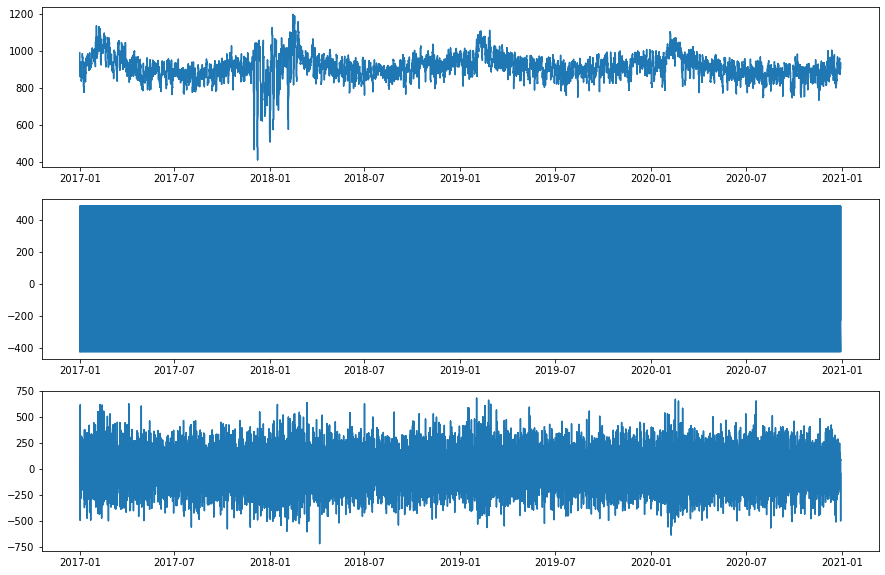

In [17]:
df = pd.DataFrame(None)
df['date'] = data[data['Date'] <= '2020-12-30']['Date']
df['target'] = data[data['Date'] <= '2020-12-30']['Usage_kWh']
df.set_index('date', inplace=True)

decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(trend)
plt.subplot(3,1,2)
plt.plot(seasonal)
plt.subplot(3,1,3)
plt.plot(residual);

In [18]:
df_new = pd.DataFrame()
df_new['trend'] = trend
df_new['seasonal'] = seasonal
df_new['residual'] = residual
df_new['target'] = df['target']
df_new.dropna(inplace=True)

y = df_new[df_new.index <= '2020-12-24'].values # до 24 вкл
y25 = df_new[df_new.index <= '2020-12-25'].values # до 25 вкл
y26 = df_new[df_new.index <= '2020-12-26'].values # до 26 вкл
y27 = df_new[df_new.index <= '2020-12-27'].values # до 27 вкл
y28 = df_new[df_new.index <= '2020-12-28'].values # до 28 вкл
y29 = df_new[df_new.index <= '2020-12-29'].values # до 29 вкл
y30 = df_new[df_new.index <= '2020-12-30'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor (декомпозиция)'
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000


Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629


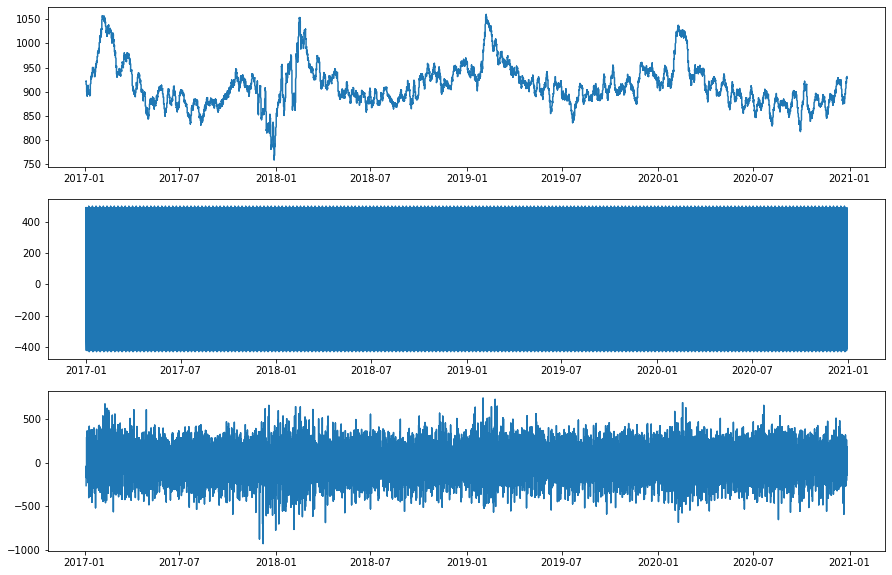

In [19]:
df = pd.DataFrame(None)
df['date'] = data[data['Date'] <= '2020-12-30']['Date']
df['target'] = data[data['Date'] <= '2020-12-30']['Usage_kWh']
df.set_index('date', inplace=True)

decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=24*7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(trend)
plt.subplot(3,1,2)
plt.plot(seasonal)
plt.subplot(3,1,3)
plt.plot(residual);

df_new = pd.DataFrame()
df_new['trend'] = trend
df_new['seasonal'] = seasonal
df_new['residual'] = residual
df_new['target'] = df['target']
df_new.dropna(inplace=True)

y = df_new[df_new.index <= '2020-12-24'].values # до 24 вкл
y25 = df_new[df_new.index <= '2020-12-25'].values # до 25 вкл
y26 = df_new[df_new.index <= '2020-12-26'].values # до 26 вкл
y27 = df_new[df_new.index <= '2020-12-27'].values # до 27 вкл
y28 = df_new[df_new.index <= '2020-12-28'].values # до 28 вкл
y29 = df_new[df_new.index <= '2020-12-29'].values # до 29 вкл
y30 = df_new[df_new.index <= '2020-12-30'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor (декомпозиция, period=24*7'
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

In [20]:
df = pd.DataFrame(None)
df['date'] = data[data['Date'] <= '2020-12-30']['Date']
df['target'] = data[data['Date'] <= '2020-12-30']['Usage_kWh']
df.set_index('date', inplace=True)

decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df_new = pd.DataFrame()
#df_new['trend'] = trend
df_new['seasonal'] = seasonal
#df_new['residual'] = residual
df_new['target'] = df['target']
df_new.dropna(inplace=True)

y = df_new[df_new.index <= '2020-12-24'].values # до 24 вкл
y25 = df_new[df_new.index <= '2020-12-25'].values # до 25 вкл
y26 = df_new[df_new.index <= '2020-12-26'].values # до 26 вкл
y27 = df_new[df_new.index <= '2020-12-27'].values # до 27 вкл
y28 = df_new[df_new.index <= '2020-12-28'].values # до 28 вкл
y29 = df_new[df_new.index <= '2020-12-29'].values # до 29 вкл
y30 = df_new[df_new.index <= '2020-12-30'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor (дек.,seasonal)'
Tuner = False

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000


In [21]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

In [22]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл

y = ExponentialSmoothing(y).fit().fittedvalues
y25 = ExponentialSmoothing(y25).fit().fittedvalues
y26 = ExponentialSmoothing(y26).fit().fittedvalues
y27 = ExponentialSmoothing(y27).fit().fittedvalues
y28 = ExponentialSmoothing(y28).fit().fittedvalues
y29 = ExponentialSmoothing(y29).fit().fittedvalues
y30 = ExponentialSmoothing(y30).fit().fittedvalues

y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'MLPRegressor (ExponentialSmoothing)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [23]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [24]:
df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997


In [25]:
df_results2.to_csv('MLP_доп_признаки.csv')

In [74]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'MLPRegressor (Weekday)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [75]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [76]:
df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [183]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
day_max = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].max()
day_min = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].min()
data['Day_max'] = [day_max[row.Date.weekday()] for i, row in data.iterrows()]
data['Day_min'] = [day_min[row.Date.weekday()] for i, row in data.iterrows()]
data.head()

,Date,Time,Usage_kWh,Day_max,Day_min
0,2017-01-01,00 - 01,570.685479,2043.740549,271.265021
1,2017-01-01,01 - 02,604.642705,2043.740549,271.265021
2,2017-01-01,02 - 03,518.732113,2043.740549,271.265021
3,2017-01-01,03 - 04,608.188829,2043.740549,271.265021
4,2017-01-01,04 - 05,714.140572,2043.740549,271.265021


In [184]:
y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'MLPRegressor (Day_min_max)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [185]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [186]:
df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [274]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+peak+seasons'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'

params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [275]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]
pivot_table = data.pivot_table(
    values='Usage_kWh', # столбец со значениями
    index=data['Date'].dt.month, # индексы - названия месяцев
    columns=data['Date'].dt.year, # столбцы - года
    aggfunc=np.mean # функция агрегации - сумма
)
month_mean = [pivot_table[row.Date.year][row.Date.month] for ind, row in data.iterrows()]
data['Month_mean'] = month_mean


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+peak+mean_month'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [276]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak
pivot_table = data.pivot_table(
    values='Usage_kWh', # столбец со значениями
    index=data['Date'].dt.month, # индексы - названия месяцев
    columns=data['Date'].dt.year, # столбцы - года
    aggfunc=np.mean # функция агрегации - сумма
)
month_mean = [pivot_table[row.Date.year][row.Date.month] for ind, row in data.iterrows()]
data['Month_mean'] = month_mean

data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [277]:
df_results2.to_csv('MLP_доп_признаки.csv')

In [279]:
month_dict = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}

meteo = pd.read_csv('meteo_data.txt',
                    delimiter='\t', header=None,
                    names=['temperature', 'humidity', 'wind_speed', 'clear', 'cloudy', 'overcast', 'rain', 'snow'])

t_list = []
h_list = []
w_list = []
for ind, row in meteo.iterrows():
    t = row.temperature.replace('°С', '')
    t = t.replace('−', '-')
    t = t.replace('+', '')
    t_list.append(float(t))
    
    h = row.humidity.replace(' %', '')
    h_list.append(int(h))
    
    w = row.wind_speed.replace(' м/с', '')
    w_list.append(w)
    
meteo['temperature'] = t_list
meteo['humidity'] = h_list
meteo['wind_speed'] = w_list

month_dict_ = {v:k for k, v in month_dict.items()}

meteo = meteo.rename(index=month_dict_)

meteo

,temperature,humidity,wind_speed,clear,cloudy,overcast,rain,snow
1,-9.0,86,3.6,2,20,6,1,1
2,-6.3,84,3.5,2,19,6,2,1
3,-2.2,78,3.4,7,17,4,2,1
4,3.9,67,3.2,9,15,4,2,0
5,10.8,62,3.2,10,15,4,1,0
6,15.8,64,2.9,12,14,3,0,0
7,17.7,74,2.5,9,17,3,0,0
8,16.2,76,2.7,11,16,2,1,0
9,9.8,84,3.1,7,17,5,1,0
10,3.8,85,3.4,5,18,5,1,1


In [281]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Month'] = data['Date'].dt.month

t = [meteo['temperature'][row.Month] for ind, row in data.iterrows()]
data['temperature'] = t 

t = [meteo['humidity'][row.Month] for ind, row in data.iterrows()]
data['humidity'] = t 

t = [meteo['wind_speed'][row.Month] for ind, row in data.iterrows()]
data['wind_speed'] = t 

t = [meteo['clear'][row.Month] for ind, row in data.iterrows()]
data['clear'] = t 

t = [meteo['cloudy'][row.Month] for ind, row in data.iterrows()]
data['cloudy'] = t 

t = [meteo['overcast'][row.Month] for ind, row in data.iterrows()]
data['overcast'] = t 

t = [meteo['rain'][row.Month] for ind, row in data.iterrows()]
data['rain'] = t 

t = [meteo['snow'][row.Month] for ind, row in data.iterrows()]
data['snow'] = t 

In [283]:
data = data.drop(['Month'], axis=1)

In [284]:
y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+meteo'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [290]:
data.head()

,Date,Time,Usage_kWh,temperature,humidity,wind_speed,clear,cloudy,overcast,rain,snow
0,2017-01-01,00 - 01,570.685479,-9.0,86,3.6,2,20,6,1,1
1,2017-01-01,01 - 02,604.642705,-9.0,86,3.6,2,20,6,1,1
2,2017-01-01,02 - 03,518.732113,-9.0,86,3.6,2,20,6,1,1
3,2017-01-01,03 - 04,608.188829,-9.0,86,3.6,2,20,6,1,1
4,2017-01-01,04 - 05,714.140572,-9.0,86,3.6,2,20,6,1,1


In [291]:
peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak
pivot_table = data.pivot_table(
    values='Usage_kWh', # столбец со значениями
    index=data['Date'].dt.month, # индексы - названия месяцев
    columns=data['Date'].dt.year, # столбцы - года
    aggfunc=np.mean # функция агрегации - сумма
)
month_mean = [pivot_table[row.Date.year][row.Date.month] for ind, row in data.iterrows()]
data['Month_mean'] = month_mean

data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]




y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'MLPRegressor'
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}

model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.666983,17430.470555,97.422666,0.849854,18.596895,None,0.015632
5,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
6,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
7,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
8,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
9,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003


In [348]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*2
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [349]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*3
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [350]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*4
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [351]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*5
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [352]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*6
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [353]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*8
Forecast_type = 'Наблюдение за раз'

X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [354]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*9
Forecast_type = 'Наблюдение за раз'

X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [355]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*14
Forecast_type = 'Наблюдение за раз'

X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [356]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 12
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [357]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 36
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'MLPRegressor(window={WINDOW})'
model = MLPRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [370]:
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [371]:
pd.concat([df_results2.iloc[:4], df_results2.iloc[8:13]])

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009
10,MLPRegressor(+peak+seasons),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.711048,14530.092321,90.349169,0.874838,283.156462,None,0.000000
11,MLPRegressor(+peak+mean_month),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.820576,16247.867018,96.889089,0.860041,119.801331,None,0.000000
12,MLPRegressor(+),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.690665,15512.546031,94.661697,0.866375,240.264622,None,0.000000


In [372]:
df_results2.iloc[4:7]

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000


In [373]:
df_results2.iloc[7:8]

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.3666,42633.597042,141.378529,0.632754,44.991345,None,0.004997


In [374]:
df_results2.iloc[13:15]

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
13,MLPRegressor(+meteo),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.468377,14641.813807,90.425583,0.873875,533.928230,None,0.042003
14,MLPRegressor(+),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.771490,14688.769681,91.667145,0.873471,623.738128,None,0.137008


In [375]:
df_results2.iloc[15:]

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
15,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.542390,16082.146265,99.224752,0.861468,67.067709,None,0.000000
16,MLPRegressor(window=48),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.282400,13240.718035,90.270200,0.885944,69.770292,None,0.004210
17,MLPRegressor(window=72),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.086013,12781.992587,84.345181,0.889896,72.254937,None,0.000000
18,MLPRegressor(window=96),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.385679,11744.354642,81.245121,0.898834,78.133830,None,0.000000
19,MLPRegressor(window=120),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.216974,13164.097054,87.151256,0.886604,93.598202,None,0.003002
20,MLPRegressor(window=144),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.336029,13768.631560,88.880555,0.881397,85.999246,None,0.003001
21,MLPRegressor(window=192),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.199636,16796.790663,103.291409,0.855312,64.806209,None,0.040003
22,MLPRegressor(window=216),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.241642,14620.442440,92.066523,0.874060,53.283562,None,0.042003
23,MLPRegressor(window=336),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.894178,17237.468785,102.154317,0.851516,55.148426,None,0.055006
24,MLPRegressor(window=12),False,"{'hidden_layer_sizes': (100,), 'activation': '...",14.917751,22447.758114,120.544014,0.806635,59.338384,None,0.001001


In [390]:
df_results2.iloc[15:26].sort_values(by=['MAPE'])

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
18,MLPRegressor(window=96),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.385679,11744.354642,81.245121,0.898834,78.133830,None,0.000000
17,MLPRegressor(window=72),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.086013,12781.992587,84.345181,0.889896,72.254937,None,0.000000
19,MLPRegressor(window=120),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.216974,13164.097054,87.151256,0.886604,93.598202,None,0.003002
16,MLPRegressor(window=48),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.282400,13240.718035,90.270200,0.885944,69.770292,None,0.004210
20,MLPRegressor(window=144),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.336029,13768.631560,88.880555,0.881397,85.999246,None,0.003001
23,MLPRegressor(window=336),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.894178,17237.468785,102.154317,0.851516,55.148426,None,0.055006
21,MLPRegressor(window=192),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.199636,16796.790663,103.291409,0.855312,64.806209,None,0.040003
22,MLPRegressor(window=216),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.241642,14620.442440,92.066523,0.874060,53.283562,None,0.042003
25,MLPRegressor(window=36),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.253332,15231.652938,98.301644,0.868795,66.056443,None,0.000910
15,MLPRegressor(window=24),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.542390,16082.146265,99.224752,0.861468,67.067709,None,0.000000


In [391]:
df_results2.to_csv('MLP_доп_признаки.csv')

In [392]:
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


In [377]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 96
feature = '(+peak+window=96)'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = MLPRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [386]:
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [387]:
len(y_pred)

168

In [388]:
df_results2 = df_results2.append({'Model':f'{model_name}{feature}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,MLPRegressor(+peak),False,"{'hidden_layer_sizes': (100,), 'activation': '...",9.655904,13115.709804,86.488395,0.887021,83.455122,None,0.000000
1,MLPRegressor(+season),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.095392,14171.505830,89.118830,0.877927,159.574660,None,0.000000
2,MLPRegressor(+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.068140,13173.387665,87.663783,0.886524,82.506755,None,0.000000
3,MLPRegressor(+season+month_mean),False,"{'hidden_layer_sizes': (100,), 'activation': '...",11.158617,16333.361888,99.086663,0.859304,92.650582,None,0.015630
4,MLPRegressor (декомпозиция)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.607393,116151.637374,291.672382,-0.000530,65.058694,None,0.000000
5,"MLPRegressor (декомпозиция, period=24*7(Сутки ...",False,"{'hidden_layer_sizes': (100,), 'activation': '...",37.654788,115938.542695,292.877396,0.001305,103.220293,None,0.015629
6,"MLPRegressor (дек.,seasonal)(Сутки за раз)",False,"{'hidden_layer_sizes': (100,), 'activation': '...",114.038343,871800.659399,927.732474,-6.509690,46.297348,None,0.000000
7,MLPRegressor (ExponentialSmoothing)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",15.366600,42633.597042,141.378529,0.632754,44.991345,None,0.004997
8,MLPRegressor (Weekday)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.278218,14955.876656,91.731301,0.871170,421.062005,None,0.006003
9,MLPRegressor (Day_min_max)(Сутки за раз),False,"{'hidden_layer_sizes': (100,), 'activation': '...",10.483676,15048.417115,90.937062,0.870373,86.049972,None,0.029009


# Разное

In [636]:
df_results3 = pd.DataFrame(None,
                      columns=['Model',
                               'MAPE', 'MSE', 'MAE', 'R2'])

In [393]:
from sklearn.ensemble import RandomForestRegressor

In [685]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 120
Forecast_type = 'Сутки за раз'
model_name = 'RandomForest (seasons, weekday, window=120)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

## Остатки

In [567]:
y_train_pred = []
y_true  = []

for i in range(120, len(y)-120, 24):
    y_true.append(y[i:i+24][:, 0])
    y_train_pred.append(model.predict(y[i-120:i].reshape(1, -1))[0])

In [580]:
y_true = np.array(y_true).reshape(1, -1)[0]
y_train_pred = np.array(y_train_pred).reshape(1, -1)[0]

In [581]:
y_true.shape, y_train_pred.shape

((34656,), (34656,))

In [582]:
e = [y_true[i] - y_train_pred[i] for i in range(len(y_true))]

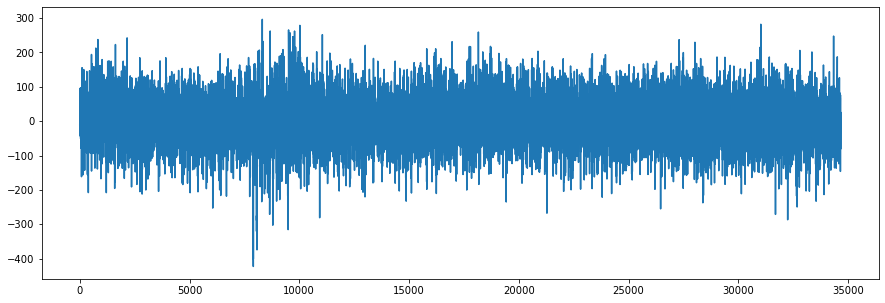

In [611]:
plt.figure(figsize=(15, 5))
plt.plot(e);

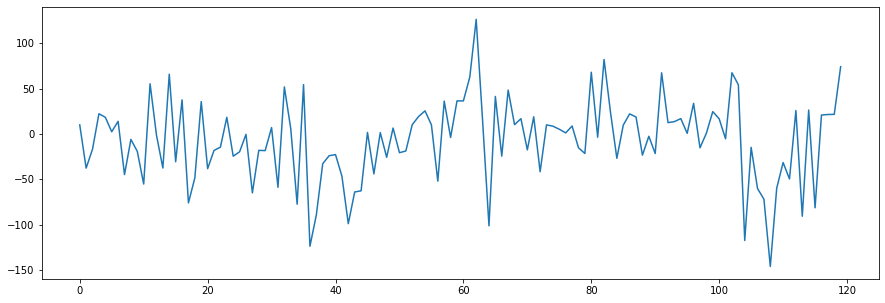

In [612]:
plt.figure(figsize=(15, 5))
plt.plot(e[-120:]);

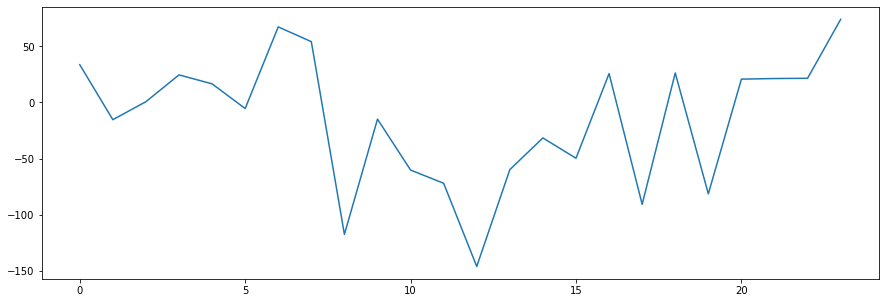

In [613]:
plt.figure(figsize=(15, 5))
plt.plot(e[-24:]);

### Использование остатков "со вчера"

In [631]:
prev_e = e[-24:]
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    corr_y = [new_y[i] + prev_e[i] for i in range(24)]
    y_pred.extend(corr_y)
    prev_e.extend(y_test[day*24:(day+1)*24][i] - new_y[i] for i in range(24))

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


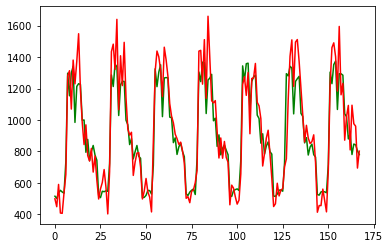

In [632]:
plt.plot(y_pred, color ='green')
plt.plot(y_test, color='red');

In [637]:
df_results3 = df_results3.append({'Model': 'Previous_residues',
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835


### Прогнозирование остатков с помощью MLP

In [687]:
WINDOW = 120

X_train_e = []
y_train_e  = []

for i in range(120, len(y)-120*2-24, 24):
    y_train_e.append(e[i:i+24])
    X_train_e.append(e[i-120:i])

In [688]:
y_train_e = np.array(y_train_e)
X_train_e = np.array(X_train_e)

In [689]:
len(y_train_e), len(X_train_e)

(1438, 1438)

In [690]:
model_name = 'MLPRegressor'
params = {'hidden_layer_sizes': (100,),
        'activation': 'relu'}
Tuner = False

model_mlp = MLPRegressor()
start_training = time.time()
model_mlp.fit(X_train_e, y_train_e)
end_training = time.time()

In [691]:
prev_e = e[-120:]
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    e_pred = model_mlp.predict(np.array(prev_e[-120:]).reshape(1, -1))[0]
    corr_y = [new_y[i] + e_pred[i] for i in range(24)]
    y_pred.extend(corr_y)
    prev_e.extend(y_test[day*24:(day+1)*24][i] - new_y[i] for i in range(24))

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


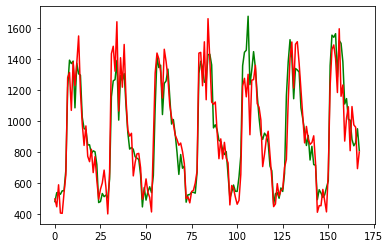

In [692]:
plt.plot(y_pred, color ='green')
plt.plot(y_test, color='red');

In [681]:
df_results3 = df_results3.append({'Model': 'Predict_residues',
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835
1,Predict_residues,10.550038,16019.065652,93.998577,0.862012


In [696]:
model_mlp = MLPRegressor()
parameters = {'activation' : ['logistic', 'tanh', 'relu'],
             'max_iter':range(150, 951, 50)}
gridsearch = GridSearchCV(model_mlp, parameters, n_jobs=-1)
gridsearch.fit(X_train_e, y_train_e)

params = {'activation': gridsearch.best_params_['activation'], 
         'max_iter':gridsearch.best_params_['max_iter']}
print(params)

model_mlp = MLPRegressor(activation=params['activation'], max_iter=params['max_iter'])
start_training = time.time()
model_mlp.fit(X_train_e, y_train_e)
end_training = time.time()

{'activation': 'logistic', 'max_iter': 150}


In [697]:
prev_e = e[-120:]
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    e_pred = model_mlp.predict(np.array(prev_e[-120:]).reshape(1, -1))[0]
    corr_y = [new_y[i] + e_pred[i] for i in range(24)]
    y_pred.extend(corr_y)
    prev_e.extend(y_test[day*24:(day+1)*24][i] - new_y[i] for i in range(24))

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [699]:
df_results3 = df_results3.append({'Model': 'Predict_residues(tuner)',
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835
1,Predict_residues,10.550038,16019.065652,93.998577,0.862012
2,Predict_residues(tuner),9.234793,12083.629798,80.636094,0.895912


### LinReg

In [704]:
from sklearn.linear_model import LinearRegression

# лин регрессия

df = pd.DataFrame(None)
df['y_true'] = np.array([y[i:i+24][:, 0] for i in range(120, len(y)-120, 24)]).reshape(-1)
df['y_pred'] = np.array([model.predict(y[i-120:i].reshape(1, -1))[0] for i in range(120, len(y)-120, 24)]).reshape(-1)
df.head()

,y_true,y_pred
0,466.572982,487.071413
1,497.376947,528.571218
2,555.296609,549.904111
3,508.741488,527.836334
4,508.540434,529.336189


In [705]:
df.shape

(34656, 2)

In [708]:
reg = LinearRegression().fit(df['y_pred'].values.reshape(-1, 1),
                             df['y_true'].values.reshape(-1, 1))

In [711]:
reg.score(df['y_pred'].values.reshape(-1, 1),
                             df['y_true'].values.reshape(-1, 1))

0.9764795303609831

In [715]:
prev_e = e[-120:]
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    reg_pred = []
    
    for i in range(24):
        reg_pred.append(new_y[i])
    
    y_pred.extend(reg_pred)

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


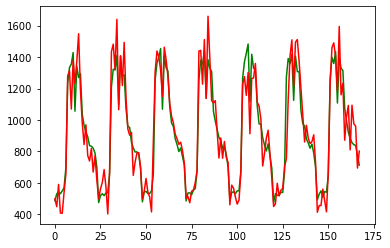

In [716]:
plt.plot(y_pred, color ='green')
plt.plot(y_test, color='red');

In [717]:
df_results3 = df_results3.append({'Model': 'Predict_true',
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835
1,Predict_residues,10.550038,16019.065652,93.998577,0.862012
2,Predict_residues(tuner),9.234793,12083.629798,80.636094,0.895912
3,Predict_true,9.230689,12037.021438,80.510660,0.896313


### Noise

In [719]:
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    noise = np.random.normal(0, 1, 24)
    new_y = [new_y[i] + noise[i] for i in range(24)]
    y_pred.extend(new_y)
end_prediction = time.time()

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


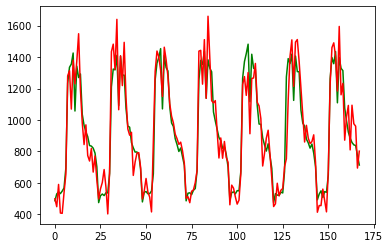

In [720]:
plt.plot(y_pred, color ='green')
plt.plot(y_test, color='red');

In [721]:
df_results3 = df_results3.append({'Model': '+noise',
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835
1,Predict_residues,10.550038,16019.065652,93.998577,0.862012
2,Predict_residues(tuner),9.234793,12083.629798,80.636094,0.895912
3,Predict_true,9.230689,12037.021438,80.510660,0.896313
4,+noise,9.228742,12023.820495,80.469216,0.896427


### Max, min

In [734]:
WINDOW = 120

X_train_max, y_train_max = [], []
for i in range(0, len(y)-24*8):
    X_train_max.append(y[i:i+WINDOW].flatten())
    y_train_max.append(max(y[i+WINDOW:i+WINDOW+24][:, 0]))

model_max = RandomForestRegressor()
start_training = time.time()
model_max.fit(X_train_max, y_train_max)
end_training = time.time()

In [735]:
pred_max = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model_max.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    pred_max.append(new_y)

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [736]:
X_train_min, y_train_min = [], []
for i in range(0, len(y)-24*8):
    X_train_min.append(y[i:i+WINDOW].flatten())
    y_train_min.append(min(y[i+WINDOW:i+WINDOW+24][:, 0]))

model_min = RandomForestRegressor()
start_training = time.time()
model_min.fit(X_train_min, y_train_min)
end_training = time.time()

In [737]:
pred_min = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model_min.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    pred_min.append(new_y)

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [761]:
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


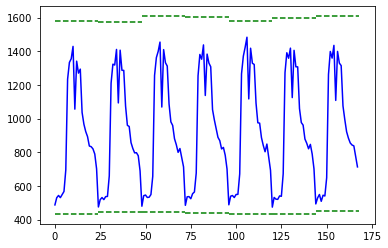

In [765]:
plt.plot(y_pred, color='blue')
for i in range(7):
    plt.hlines(pred_min[i], i*24, (i+1)*24, color='green', linestyles='dashed')
    plt.hlines(pred_max[i], i*24, (i+1)*24, color='green', linestyles='dashed')

In [769]:
corr_pred = []
for i in range(7):
    corr_max = np.argmax(y_pred[i*24:(i+1)*24])
    corr_min = np.argmin(y_pred[i*24:(i+1)*24])
    for index, yi in enumerate(y_pred[i*24:(i+1)*24]):
        if index != corr_max and index != corr_min:
            corr_pred.append(yi)
        elif index == corr_max:
            corr_pred.append(pred_max[i])
        elif index == corr_min:
            corr_pred.append(pred_min[i])

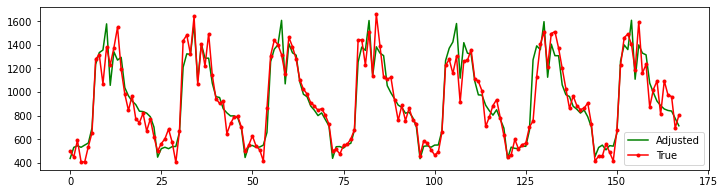

In [792]:
plt.figure(figsize=(12, 3))
plt.plot(corr_pred, color ='green', label='Adjusted')
plt.plot(y_test, color='red', label='True', marker='.')
#plt.plot(y_pred, color='blue', label='Prediction')
plt.legend();

In [771]:
df_results3 = df_results3.append({'Model': 'predict min-max',
                        'MAPE':mape(y_test, corr_pred),
                        'MSE':mse(y_test, corr_pred),
                        'MAE':mae(y_test, corr_pred),
                        'R2':r2(y_test, corr_pred)},
                                                                ignore_index=True)
df_results3

,Model,MAPE,MSE,MAE,R2
0,Previous_residues,10.611883,16271.713614,95.917775,0.859835
1,Predict_residues,10.550038,16019.065652,93.998577,0.862012
2,Predict_residues(tuner),9.234793,12083.629798,80.636094,0.895912
3,Predict_true,9.230689,12037.021438,80.510660,0.896313
4,+noise,9.228742,12023.820495,80.469216,0.896427
5,predict min-max,9.551067,12920.249522,83.697382,0.888705


In [785]:
df_results3.iloc[5:6]

,Model,MAPE,MSE,MAE,R2
5,predict min-max,9.551067,12920.249522,83.697382,0.888705


In [780]:
df_ = pd.DataFrame(None)
df_['True'] = y_test
df_['Prediction'] = y_pred
df_['Adjusted'] = corr_pred
df_['Residues_pred'] = [y_test[i] - y_pred[i] for i in range(168)]
df_['Residues_adj'] = [y_test[i] - corr_pred[i] for i in range(168)]
df_.head(24)

,True,Prediction,Adjusted,Residues_pred,Residues_adj
0,498.574076,487.176365,435.754451,11.397711,62.819625
1,448.325927,529.850552,529.850552,-81.524625,-81.524625
2,589.959784,543.243727,543.243727,46.716057,46.716057
3,408.063429,530.399615,530.399615,-122.336186,-122.336186
4,406.263067,549.281856,549.281856,-143.018789,-143.018789
5,537.177409,566.870037,566.870037,-29.692628,-29.692628
6,654.075987,694.773061,694.773061,-40.697074,-40.697074
7,1280.054257,1233.913686,1233.913686,46.140571,46.140571
8,1313.430974,1333.639702,1333.639702,-20.208728,-20.208728
9,1069.302625,1355.210026,1355.210026,-285.907402,-285.907402


In [802]:
from sklearn.tree import export_text

In [808]:
data.head()

,Date,Time,Usage_kWh,Winter,Summer,Fall,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2017-01-01,00 - 01,570.685479,1,0,0,0,0,0,0,0,0
1,2017-01-01,01 - 02,604.642705,1,0,0,0,0,0,0,0,0
2,2017-01-01,02 - 03,518.732113,1,0,0,0,0,0,0,0,0
3,2017-01-01,03 - 04,608.188829,1,0,0,0,0,0,0,0,0
4,2017-01-01,04 - 05,714.140572,1,0,0,0,0,0,0,0,0


Index(['Usage_kWh', 'Winter', 'Summer', 'Fall', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday'],
      dtype='object')

In [828]:
feature_names = [f'{col} t-{i}' for i in range(121, 1, -1) for col in data.columns[2:]]
feature_names[:15]

['Usage_kWh t-121',
 'Winter t-121',
 'Summer t-121',
 'Fall t-121',
 'Monday t-121',
 'Tuesday t-121',
 'Wednesday t-121',
 'Thursday t-121',
 'Friday t-121',
 'Saturday t-121',
 'Usage_kWh t-120',
 'Winter t-120',
 'Summer t-120',
 'Fall t-120',
 'Monday t-120']

In [829]:
print(export_text(model.estimators_[0], feature_names=feature_names))

|--- Usage_kWh t-21 <= 925.79
|   |--- Usage_kWh t-86 <= 855.28
|   |   |--- Usage_kWh t-58 <= 835.26
|   |   |   |--- Usage_kWh t-104 <= 825.28
|   |   |   |   |--- Usage_kWh t-77 <= 722.92
|   |   |   |   |   |--- Usage_kWh t-51 <= 830.34
|   |   |   |   |   |   |--- Usage_kWh t-120 <= 852.70
|   |   |   |   |   |   |   |--- Usage_kWh t-35 <= 1039.38
|   |   |   |   |   |   |   |   |--- Usage_kWh t-17 <= 651.38
|   |   |   |   |   |   |   |   |   |--- value: [775.60, 1333.64, 1045.68, 1614.04, 1293.16, 661.39, 1014.77, 1256.92, 1403.72, 1084.98, 805.86, 907.23, 870.91, 975.87, 925.36, 720.04, 657.06, 753.41, 806.55, 716.72, 669.45, 709.28, 861.05, 790.77]
|   |   |   |   |   |   |   |   |--- Usage_kWh t-17 >  651.38
|   |   |   |   |   |   |   |   |   |--- Summer t-90 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Usage_kWh t-52 <= 578.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Usage_kWh t-52 >  5

In [835]:
sum_pred = np.sum([y_pred[i*24:(i+1)*24] for i in range(7)], axis=1)
sum_true = np.sum([y_true[i*24:(i+1)*24] for i in range(7)], axis=1)
sum_corr = np.sum([corr_pred[i*24:(i+1)*24] for i in range(7)], axis=1)
mape(sum_true, sum_pred), mape(sum_true, sum_corr)

(6.4737297337008295, 6.539559382007303)